In [1]:
### import packages ###
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import fsps     # governs the fundamental stellar population synthesis models
import sedpy    # contains some routines for computing projecting spectra onto filter bandpasses

from astropy.io import fits
import astropy as ap
from astropy.cosmology import WMAP9

sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling

from prospect.utils.obsutils import fix_obs

import emcee
import dynesty

from prospect.models.sedmodel import SedModel
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import transforms

from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot

from prospect.fitting import fit_model

from prospect.io import write_results as writer

from prospect import prospect_args  # - Parser with default arguments -

### re-defining plotting defaults ###
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)      #RunTimeWarnings are driving me nuts

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [2]:
start_time = time.time()

In [3]:
### Function to convert mJy to Jy ###
def mJy_to_maggies(mJy):
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

In [4]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

### Import galaxy redshift data ###
G_Redshift_csv = np.genfromtxt('/mnt/c/Users/emma_d/ASTR_Research/Data/G_Redshift.csv', delimiter = ',')
G_Redshift_full = G_Redshift_csv[:,1]   # only take redshift column

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)  # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift_full) # cosmological redshift

In [5]:
### Choose a galaxy (0 to 57) ###
# Explorer Path = C:\Users\emma_d\ASTR_Research\Galaxy_output\G0
galaxy_num = 8

Template_Type = 'parametric'
if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

G_Redshift = G_Redshift_full[galaxy_num]
ldist_Mpc = ldist_Mpc_units[galaxy_num].value
tage_of_univ = WMAP9.age(G_Redshift).value   # Gyr

print('This is for Galaxy R', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)

This is for Galaxy R 9
The Date is 21Jun02
The template type is parametric


In [6]:
# Burst_SFH = {'Type':'burst_sfh', 'fixed_params':{'tburst', 'fburst', 'fage_burst'}, 'free_params':{}, 
#     'tburst':{'init': 0.5, 'depends_on': tburst_from_fage(tage=0.0, fage_burst=0.0, **extras)}, 
#     'fburst':{'init':.10, 'prior': priors.TopHat(mini=0.0, maxi=0.5)}, 
#     'fage_burst':{'init': .50, 'prior': priors.TopHat(mini=0.5, maxi=1.0)}}

# Dirichlet_SFH = {'Type': 'dirichlet_sfh', 'fixed_params':{'zred', 'mass', 'sfh', 'imf_type', 'dust_type', 'agebins'},
#     'logzsol':{'prior':priors.TopHat(mini=0.0,maxi=2.0)},
#     'dust2':{'prior': priors.TopHat(mini=0.0,maxi=2.0)},
#     'z_fraction':{'prior':priors.Beta(mini=0.0,maxi=1.0,alpha=1.0,beta=1.0)},
#     'total_mass':{'prior':priors.LogUniform(mini=100000000.0,maxi=1000000000000.0)},
#     'zred':}

# Parametric_SFH = {}

# Fit_Type = np.array["burst_sfh", "dirichlet_sfh", "parametric_sfh"]

In [7]:
### Flux data ###
FFUV = mJy_to_maggies(AGN_data.field(4))
FNUV = mJy_to_maggies(AGN_data.field(6))
Fu = mJy_to_maggies(AGN_data.field(8))
Fg = mJy_to_maggies(AGN_data.field(10))
Fr = mJy_to_maggies(AGN_data.field(12))
Fi = mJy_to_maggies(AGN_data.field(14))
Fz = mJy_to_maggies(AGN_data.field(16))
FJ = mJy_to_maggies(AGN_data.field(18))       #Turned on 2mass
FH = mJy_to_maggies(AGN_data.field(20))       #Turned on 2mass
FKs = mJy_to_maggies(AGN_data.field(22))      #Turned on 2mass
F3_4 = mJy_to_maggies(AGN_data.field(24))
F4_6 = mJy_to_maggies(AGN_data.field(26))
F12 = mJy_to_maggies(AGN_data.field(28))
F22 = mJy_to_maggies(AGN_data.field(31))
F70 = mJy_to_maggies(AGN_data.field(33))
F100 = mJy_to_maggies(AGN_data.field(35))
F160 = mJy_to_maggies(AGN_data.field(37))
F250 = mJy_to_maggies(AGN_data.field(39))
F350 = mJy_to_maggies(AGN_data.field(42))
F500 = mJy_to_maggies(AGN_data.field(45))

Flux_Data = np.column_stack((FFUV, FNUV, Fu, Fg, Fr, Fi, Fz, F3_4, F4_6, F12, F22, F70, F100, F160, F250, F350, F500, FJ, FH, FKs))

### Filter uncertainty in mJy ###
FFUVe = mJy_to_maggies(AGN_data.field(5))
FNUVe = mJy_to_maggies(AGN_data.field(7))
Fue = mJy_to_maggies(AGN_data.field(9))
Fge = mJy_to_maggies(AGN_data.field(11))
Fre = mJy_to_maggies(AGN_data.field(13))
Fie = mJy_to_maggies(AGN_data.field(15))
Fze = mJy_to_maggies(AGN_data.field(17))
FJe = mJy_to_maggies(AGN_data.field(19))
FHe = mJy_to_maggies(AGN_data.field(21))
FKse = mJy_to_maggies(AGN_data.field(23))
F3_4e = mJy_to_maggies(AGN_data.field(25))
F4_6e = mJy_to_maggies(AGN_data.field(27))
F12e = mJy_to_maggies(AGN_data.field(29))
F22e = mJy_to_maggies(AGN_data.field(32))
F70e = mJy_to_maggies(AGN_data.field(34))
F100e = mJy_to_maggies(AGN_data.field(36))
F160e = mJy_to_maggies(AGN_data.field(38))
F250e = mJy_to_maggies(AGN_data.field(40))
F350e = mJy_to_maggies(AGN_data.field(43))
F500e = mJy_to_maggies(AGN_data.field(46))

In [8]:
### Build a dictionary of observational data to use in fit ###
def build_obs( **extras):     #snr = 10 , ldist = 10
    obs = {}

    # Filters (same order as photometric data) ###
    galex = ['galex_FUV', 'galex_NUV']
    galex_unc = FFUVe, FNUVe

    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    sdss_unc = Fue, Fge, Fre, Fie, Fze

    allWise = ['wise_w{0}'.format(b) for b in ['1','2','3','4']]
    allWise_unc = F3_4e, F4_6e, F12e, F22e

    herschel_pacs = ['herschel_pacs_{0}'.format(b) for b in ['70','100','160']]
    herschel_pacs_unc = F70e, F100e, F160e

    herschel_spire = ['herschel_spire_{0}'.format(b) for b in ['250','350','500']]
    herschel_spire_unc = F250e, F350e, F500e

    twomass = ['twomass_{0}'.format(b) for b in ['H','J','Ks']]          #Turned off 2mass
    twomass_unc = FHe, FJe, FKse

    filternames = galex + sdss + allWise + herschel_pacs + herschel_spire + twomass
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Flux data (in same order as filters) in maggies ###
    obs["maggies"] = Flux_Data[galaxy_num]

    # Uncertainties (same order as filters) in maggies ### 
    uncertainty_cols = galex_unc, sdss_unc, allWise_unc, herschel_pacs_unc, herschel_spire_unc , twomass_unc

    maggies_uncertainy = np.vstack(uncertainty_cols).T      #transposed to get the row data not the column data
    obs["maggies_unc"] = maggies_uncertainy[galaxy_num]

    obs["phot_mask"] = np.full((len(Flux_Data[galaxy_num])), True, dtype=bool)

    ### Array of effective wavelengths for each filter (not necessary, but can be useful for plotting) ###
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None    # vector of vaccum λs in angstroms
    obs["spectrum"] = None      # in maggies
    obs['unc'] = None           # spectral uncertainties
    obs['mask'] = None

    obs = fix_obs(obs)      # Ensures all required keys are present in the obs dictionary

    return obs

In [9]:
run_params = {}
run_params["ldist"] = ldist_Mpc     # luminosity distance to assume for translating M into m

In [10]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
# print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
# print("--------\nFilter objects:\n")
# print(obs["filters"])

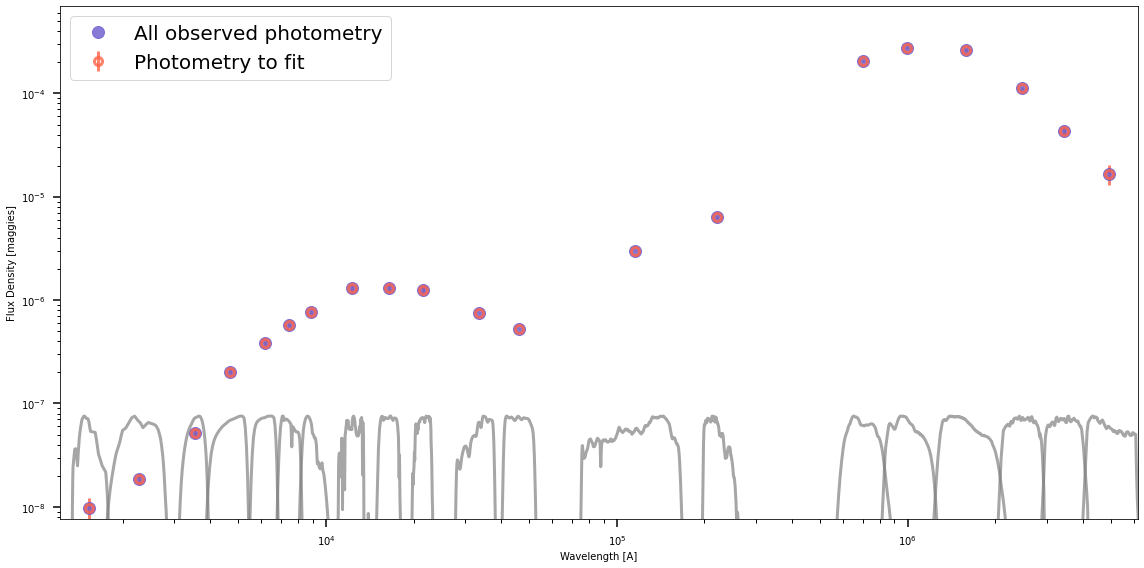

In [11]:
### Plot flux data ###

wphot = obs["phot_wave"]
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4  
figure(figsize=(16,8))

### Plot all data ###
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

### overplot only data we want to fit (using phot_mask) ###
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

### Plot filters ###
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)


xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()


savefig(Galaxy_Path + 'G{0}_{1}_{2}_plot_data_1'.format(galaxy_num, Template_Type, ts))

In [12]:
from prospect.models import priors
"""
    mass: 
    N:          Mass parameter here is a scalar, so it has N=1
    isfree:     We will be fitting for the mass, so it is a free parameter
    init:       Initial value. For fixed parameters this is the value that will always be used. 
    prior:      Sets the prior probability for the parameter
    init_disp:  Sets the initial dispersion to use when generating clouds of emcee "walkers".
                    It is not required, but can be very helpful.
    disp_floor: Sets the minimum dispersion to use when generating clouds of emcee "walkers".  
                    It is not required, but can be useful if 
    units:      This is not required, but can be helpful
"""
mass_param = {"name": "mass",
              "N": 1,
              "isfree": True, 
              "init": 1e10,
              "prior": priors.LogUniform(mini=1e8, maxi=1e12),
              "init_disp": 1e8, 
              "disp_floor": 1e8, 
              "units": "solar masses formed",
              }


In [13]:
from prospect.models.templates import TemplateLibrary
# Look at all the prepackaged parameter sets
# TemplateLibrary.show_contents()

# TemplateLibrary.describe("burst_sfh")
# TemplateLibrary.describe("dirichlet_sfh")
TemplateLibrary.describe("parametric_sfh")
# TemplateLibrary.describe("agn")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


In [14]:
### Build a prospect.models.SedModel object ###

def build_model(object_redshift=G_Redshift, tage_univ = tage_of_univ, ldist=ldist_Mpc, fixed_metallicity=None, add_duste=False, **extras):    

    ### Get (a copy of) the prepackaged model set dict (dict of dicts, keyed by parameter name) ###
    model_params = TemplateLibrary["parametric_sfh"]        # ON
    model_params.update(TemplateLibrary["dirichlet_sfh"])   # ON

    ### Dirichlet SFH ###   # All ON
    model_params['sfh']['init'] = 4                  #FSPS_index (3: Diri, 4:param   ??)
    model_params['agebins']['init'] = [[0.0, 8.0], [8.0, 9.0], [9.0, 10.0]]     #log(yr)
    model_params['z_fraction']['init'] = [0, 0]
    model_params['z_fraction']['prior'] = priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0) #Aux var used for sampling sfr_fractions from dirichlet. This *must* be adjusted depending on the nbins
    model_params['mass']['depends_on'] = transforms.zfrac_to_masses   #Msol:  mass in each bin. Depends on other free & fixed parameters. It's length needs to be modified based on the nbins

    ### AGN ####
    # model_params['fagn'] = .0001
    # model_params['agn_tau'] = 5.0
    # model_params['add_agn_dust'] = True

    ### Burst SFH ###
    # model_params["tburst"]["init"] = 0.5
    # model_params["fburst"]["init"] = .10       # 10% (.1) of mass from burst     
    # model_params["fage_burst"]["init"] = .50   # 50% (.5) 

    # model_params["tburst"]["prior"] =   #tburst_from_fage(tage=0.0, fage_burst=0.0, **extras)
    # model_params["fburst"]["prior"] = priors.TopHat(mini=0.0, maxi=0.5)
    # model_params["fage_burst"]["prior"] = priors.TopHat(mini=0.5, maxi=1.0)
     
    # model_params['tburst']['depends_on'] = tburst_from_fage 

    # #------------------------------------------------- #added 5/26 for alpha
    # model_params = TemplateLibrary["alpha"]
    # model_params['dust_type'] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"}
    # model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=4.0)
    # model_params["dust1"] = {"N": 1, "isfree": False, 
    #                         'depends_on': transforms.dustratio_to_dust1, 
    #                         "init": 0.0, "units": "optical depth towards young stars"}
    # model_params["dust_ratio"] = {"N": 1, "isfree": True,
    #                         "init": 1.0, "units": "ratio of birth-cloud to diffuse dust",
    #                         "prior": priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0,
    #                         sigma=0.3)}
    # model_params["dust_index"] = {"N": 1, "isfree": True,
    #                         "init": 0.0, "units": "power-law multiplication of Calzetti",
    #                         "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
    # # in Gyr
    # alpha_agelims = np.array([1e-9, 0.1, 0.3, 1.0, 3.0, 6.0, 13.6])
    # model_params = prospect.models.templates.adjust_dirichlet_agebins(model_params, agelims=(np.log10(alpha_agelims) + 9))
    # #From dirichlet before
    # model_params['z_fraction']['init'] = [0, 0, 0, 0, 0] # 0, 0 fails
    # # model_params['z_fraction']['prior'] = priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0) #Aux var used for sampling sfr_fractions from dirichlet. This *must* be adjusted depending on the nbins
    # model_params['mass']['depends_on'] = transforms.zfrac_to_masses   #Msol:  mass in each bin. Depends on other free & fixed parameters. It's length needs to be modified based on the nbins
    # #-------------------------------------------------



    ### parametric SFH ###
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"} # added in

    
    ### Change initial values to values appropriate for our objects and data
    model_params["dust2"]["init"] = 0.3        #initially 0.05
    model_params["logzsol"]["init"] = -0.5      # Should I try -.7? (from git)
    # model_params["tage"]["init"] = 5            #time from now to when stars formed # ON
    model_params["mass"]["init"] = 1e10

    model_params['tage']['prior'] = priors.LogUniform(mini= 0.01, maxi=tage_univ) # ON   #added in
    
    # Look into how to adjust these for PSBs
    model_params["dust2"]["prior"] = priors.TopHat(mini=1e-6, maxi=4.0)   #changed maxi from 2 to 4, 0 to 1e-6
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)       # ON
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e8, maxi=1e12)  

    ### For emcee: it is useful to provide a min scale for the cloud of walkers (default = 0.01)
    model_params["mass"]["disp_floor"] = 1e8
    model_params["tau"]["disp_floor"] = 1.0          # ON
    model_params["tage"]["disp_floor"] = 1.0        # ON
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        ### make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        ### And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # update `model_params` with the parameters described in the`dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = G_Redshift
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

In [15]:
### Build model and view model ###
model = build_model(**run_params)
# print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
# print("Initial parameter dictionary:\n{}".format(model.params))


Initial free parameter vector theta:
  [-5.e-01  3.e-01  1.e+00  1.e+00  0.e+00  0.e+00  1.e+10]

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/parameters.py:137: RuntimeWarning: z_fraction has wrong length prior, should be 2
  warnings.warn(msg.format(p, n), RuntimeWarning)


In [16]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A value of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`) (see python-FSPS)
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [17]:
sps = build_sps(**run_params)
# help(sps.get_spectrum)

# FAILS IF I CHANGE model_params['sfh']['init'] = 4 TO A 3!!

mass =  [1.e+10 0.e+00 0.e+00]
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496


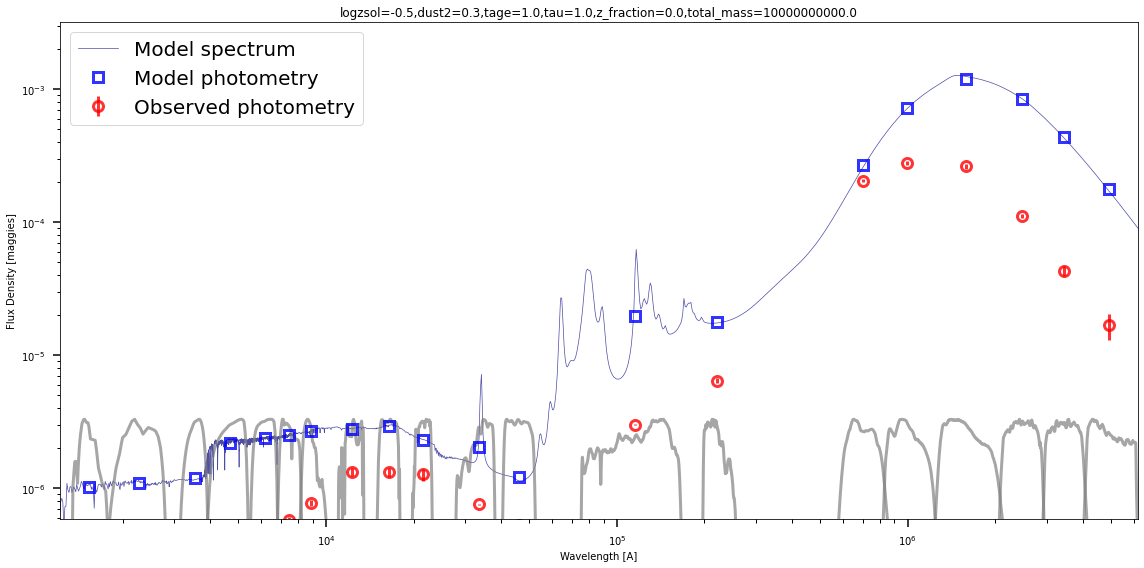

In [18]:
### View Model ###
### prediction for the data from any set of model params

### Generate the model SED at the initial value of theta ###
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]    # photometric effective wavelengths
if obs["wavelength"] is None:
    # spectroscopic wavelengths
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a              # redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_SED_plot_2'.format(galaxy_num, Template_Type, ts))


In [19]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""

run_params["verbose"] = False

### Prospector has its own lnprobfn ###
# help(lnprobfn)

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 
# Dynamic nested sampling with dynesty

# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# print(sps.ssp.libraries)

# help(fit_model)

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/parameters.py:137: RuntimeWarning: z_fraction has wrong length prior, should be 2
  warnings.warn(msg.format(p, n), RuntimeWarning)


In [20]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# Start minimization from nmin seperate places
# 1) based on current values of each param
# 2+) drawn from prior
# starting from extra draws = guard against local 
# mins or problems from starting at prior edge
run_params["nmin"] = 5 # initially 2, try 1

output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573837909767
ssp.stellarmass =  0.7380573837909767
ssp.stellarmass =  0.7380573837909767
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573828202472
ssp.stellarmass =  0.7380573828202472
ssp.stellarmass =  0.7380573828202472
ssp.stellarmass =  0.7380573838264998
ssp.stellarmass =  0.7380573838264998
ssp.stellarmass =  0.7380573838264998
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarmass =  0.7380573836692496
ssp.stellarm

model.theta [-7.59826538e-01  3.03977555e+00  2.76569473e-02  2.78125570e+00
  4.11516339e-02  8.67409615e-03  2.03593644e+08]
ind_best =  1
theta_best =  [-7.59826538e-01  3.03977555e+00  2.76569473e-02  2.78125570e+00
  4.11516339e-02  8.67409615e-03  2.03593644e+08]
0.9340726937490917
0.9340726937490917
0.9340726937490917


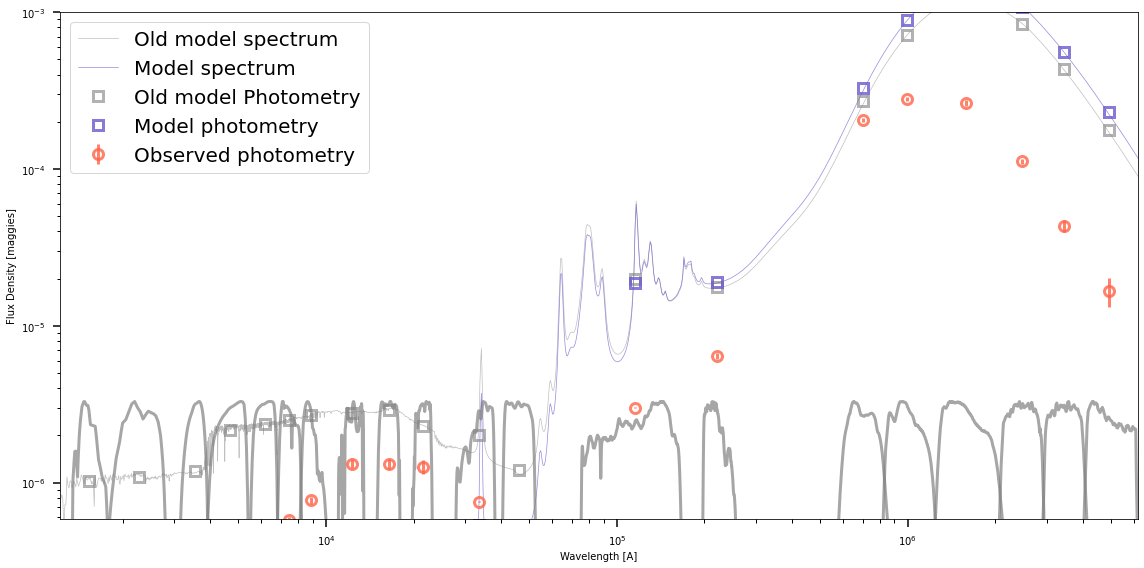

In [21]:
print("model.theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_best = results[ind_best].x.copy()
print("theta_best = ", theta_best)

Imodel_theta = model.theta          # added in
Imodel_theta_best = theta_best      # added in

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# wspec * (1 + model.params['zred'])

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))

In [22]:
# False = no 2nd optimization before emcee sampling (optimization in dict = (None, 0.))
# True = 2nd optimization before sampling begins (optimization in dict = populated)
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [ ]:
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

In [ ]:
run_params["dynesty"] = False
run_params["optmization"] = False
run_params["emcee"] = True
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [ ]:
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--add_duste', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--ldist', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"
                          "(for case of absolute mags)"))
args, _ = parser.parse_known_args()
cli_run_params = vars(args)
# print(cli_run_params)

In [ ]:
ts = time.strftime("%y%b%d", time.localtime())
hfile = 'G{0}_{1}_{2}_1mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params)# build_all(**run_params)

In [ ]:
### Use to save results to disk ###
# hfile = "demo_emcee_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

In [ ]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
# result, obs, _ = reader.results_from("demo_{}_mcmc.h5".format(results_type), dangerous=False)       #change to file that was just generated
# result, obs, _ = reader.results_from('G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)
result, obs, _ = reader.results_from('G{0}_{1}_21May12_1mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
# model = reader.get_model(result)
# sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
# print(result.keys())

In [ ]:
# result

In [ ]:
### Plotting Parameter Traces ###
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

In [ ]:
### Corner Plot ###
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

Fmodel_theta_best = theta_best  # added in
Fmodel_theta_max = theta_max    # added in

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(7,7,figsize=(30,30))[0])

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

In [ ]:
# print(model.theta)
# print(theta_best)
# print(theta_max)

print(Fmodel_theta_best)  #Theta best
print(Fmodel_theta_max)   #Theta max
print(Imodel_theta)
print(Imodel_theta_best)

randint = np.random.randint
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta_theta = result['chain'][randint(nwalkers), randint(niter)]

print(theta_theta)         #theta
print(result['bestfit'])

# model.theta [-2.34383847e-01  4.33013119e-01  4.03589803e+00  1.35007310e+00
#   0.00000000e+00  0.00000000e+00  1.48686765e+10]

In [ ]:
# https://github.com/bd-j/prospector/issues/186


# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

print(len(mphot), len(wphot))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [ ]:
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")